In [1]:
# Imports
from dataloader import get_utkface_loaders
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch
from models import *

In [22]:
# Load data
BATCH_SIZE = 32
NUM_TRAIN = 50000
NUM_VALID = 10000
train_loader, val_loader, test_loader = get_utkface_loaders(dataset_path="./dataset", batch_size=BATCH_SIZE, num_train=NUM_TRAIN, num_valid=NUM_VALID)

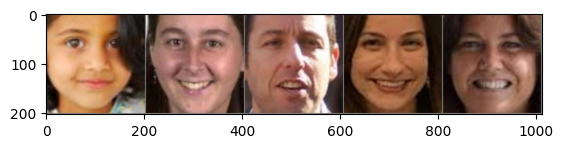

In [23]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

indices = np.random.choice(len(images), 5, replace=False)
random_images = images[indices]

# Show images
imshow(vutils.make_grid(random_images))

In [25]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu
